# Exploring Dandiset 001195: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State

**⚠️ IMPORTANT:** This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

## Overview

This notebook explores Dandiset 001195, which contains data supporting the research on dorsal raphe dopamine projections and their role in loneliness-like states. The dataset is available at [https://dandiarchive.org/dandiset/001195](https://dandiarchive.org/dandiset/001195).

The Dandiset includes both intracellular electrophysiology (patch-clamp recording) data and calcium imaging data, allowing us to investigate neuronal activity at different scales. This notebook will walk through:

1. Loading and exploring the Dandiset metadata
2. Examining intracellular electrophysiology data from the dorsal raphe nucleus
3. Analyzing calcium imaging data from the central amygdala (CeA)
4. Summarizing findings and suggesting future analysis directions

## Required Packages

The following Python packages are required to run this notebook:

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import remfile
import pynwb
import scipy.signal as signal
import seaborn as sns

# Configure plotting style
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 6)

## Loading the Dandiset

In [2]:
# Connect to DANDI archive
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001195")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Dandiset name: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State
Dandiset URL: https://dandiarchive.org/dandiset/001195/0.250408.1733

Found 230 assets in the dataset

First 5 assets:
- sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb
- sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb
- sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb
- sub-23/sub-23_ses-20150324T154615_slice-slice-2_cell-B2_icephys.nwb
- sub-23/sub-23_ses-20150324T152016_slice-slice-2_cell-B1_icephys.nwb


## Part 1: Intracellular Electrophysiology Data Analysis

First, we'll explore intracellular electrophysiology data from the dorsal raphe nucleus. This data was collected using patch-clamp recording techniques, which allow for high-resolution measurement of neuronal electrical activity.

We'll select an NWB file containing intracellular electrophysiology recordings:

In [3]:
# Define the URL for the NWB file we'll analyze
icephys_asset_id = "9029e9f3-949a-4cf3-ade5-48542a1a59b7"
icephys_url = f"https://api.dandiarchive.org/api/assets/{icephys_asset_id}/download/"
print(f"Loading electrophysiology NWB file: {icephys_asset_id} (sub-235, cell-C1)")

# Load the file
remote_file = remfile.File(icephys_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb_ephys = io.read()

# Display basic metadata
print(f"Session description: {nwb_ephys.session_description}")
print(f"Subject ID: {nwb_ephys.subject.subject_id}")
print(f"Experiment date: {nwb_ephys.session_start_time}")

Loading electrophysiology NWB file: 9029e9f3-949a-4cf3-ade5-48542a1a59b7 (sub-235, cell-C1)


Session description: baseline
Subject ID: 235
Experiment date: 2020-09-21 13:10:57-07:00


### 1.1 Examining Current Clamp Responses

Let's examine a current clamp recording from this dataset. In a current clamp recording, current is injected into the neuron while measuring the membrane voltage response.


Found current_clamp-response-02-ch-0
Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
Starting time: 71.0 seconds
Rate: 10000.0 Hz
Data shape: (50000,)

Found stimulus-02-ch-0
Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA


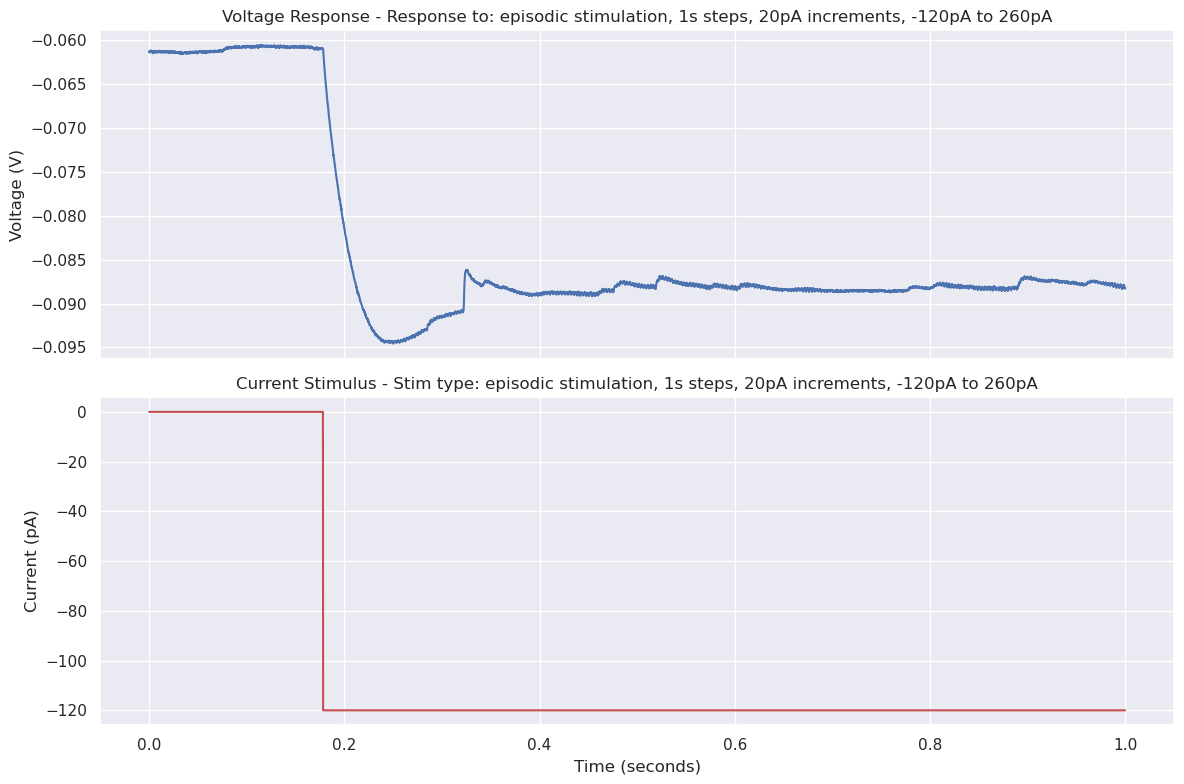

In [4]:
# Select one of the current clamp response series
response_name = "current_clamp-response-02-ch-0"
stimulus_name = "stimulus-02-ch-0"

if response_name in nwb_ephys.acquisition:
    response = nwb_ephys.acquisition[response_name]
    print(f"\nFound {response_name}")
    print(f"Description: {response.description}")
    print(f"Starting time: {response.starting_time} {response.starting_time_unit}")
    print(f"Rate: {response.rate} Hz")
    print(f"Data shape: {response.data.shape}")
    
    # Load a subset of data
    data_subset = response.data[0:10000]  # First 1 second of data (at 10kHz sampling rate)
    
    # Convert to actual voltage
    voltage_data = data_subset * response.conversion
    
    # Load corresponding stimulus
    if stimulus_name in nwb_ephys.stimulus:
        stimulus = nwb_ephys.stimulus[stimulus_name]
        print(f"\nFound {stimulus_name}")
        print(f"Description: {stimulus.description}")
        
        # Load stimulus data
        stim_data_subset = stimulus.data[0:10000]  # First 1 second, matching the response
        
        # Convert to actual current
        current_data = stim_data_subset * stimulus.conversion  # In amperes
        current_data_pA = current_data * 1e12  # Convert to pA for easier reading
        
        # Create a time vector (in seconds)
        time = np.arange(len(voltage_data)) / response.rate
        
        # Plot the response and stimulus
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot voltage response
        axs[0].plot(time, voltage_data, 'b')
        axs[0].set_ylabel('Voltage (V)')
        axs[0].set_title(f'Voltage Response - {response.description}')
        
        # Plot current stimulus
        axs[1].plot(time, current_data_pA, 'r')
        axs[1].set_xlabel('Time (seconds)')
        axs[1].set_ylabel('Current (pA)')
        axs[1].set_title(f'Current Stimulus - {stimulus.description}')
        
        plt.tight_layout()
else:
    print(f"Could not find response {response_name}")

### 1.2 Current-Voltage (I-V) Relationship

The current-voltage (I-V) relationship characterizes the neuron's passive membrane properties. Let's examine it by looking at the steady-state responses to different current injections.


Found 8 stimulus-response pairs for I-V analysis


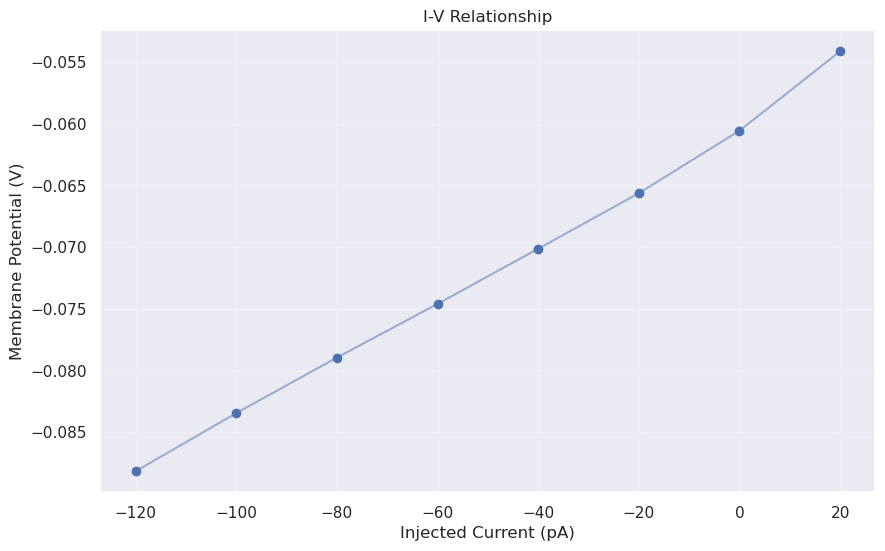

In [5]:
# Find several response traces with different stimulus intensities
response_series = []
stimulus_series = []

for i in range(2, 10):  # Look at a range of stimulus intensities
    response_key = f"current_clamp-response-0{i}-ch-0"
    stimulus_key = f"stimulus-0{i}-ch-0"
    
    if response_key in nwb_ephys.acquisition and stimulus_key in nwb_ephys.stimulus:
        response_series.append(nwb_ephys.acquisition[response_key])
        stimulus_series.append(nwb_ephys.stimulus[stimulus_key])

if response_series:
    print(f"\nFound {len(response_series)} stimulus-response pairs for I-V analysis")
    
    # Extract steady-state responses and stimulus intensities
    steady_state_voltages = []
    stimulus_intensities = []
    
    for resp, stim in zip(response_series, stimulus_series):
        # Get the middle of the trace (avoiding transients)
        resp_data = resp.data[5000:9000]  # From 0.5s to 0.9s (assuming 1s stimulation)
        stim_data = stim.data[5000:9000]  # Same time range
        
        # Convert to physical units
        voltage = np.mean(resp_data) * resp.conversion
        current = np.mean(stim_data) * stim.conversion * 1e12  # pA
        
        steady_state_voltages.append(voltage)
        stimulus_intensities.append(current)
    
    # Plot I-V relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(stimulus_intensities, steady_state_voltages, c='b', marker='o')
    plt.plot(stimulus_intensities, steady_state_voltages, 'b-', alpha=0.5)
    plt.xlabel('Injected Current (pA)')
    plt.ylabel('Membrane Potential (V)')
    plt.title('I-V Relationship')
    plt.grid(True, alpha=0.3)

### 1.3 Analyzing Action Potentials

Now let's examine action potentials in response to stronger current injections. Action potentials are the fundamental unit of neuronal communication.


Found current_clamp-response-19-ch-0
Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
Stimulus current: 74.59 pA
Estimated resting potential: -0.062 V
Found 356 action potentials


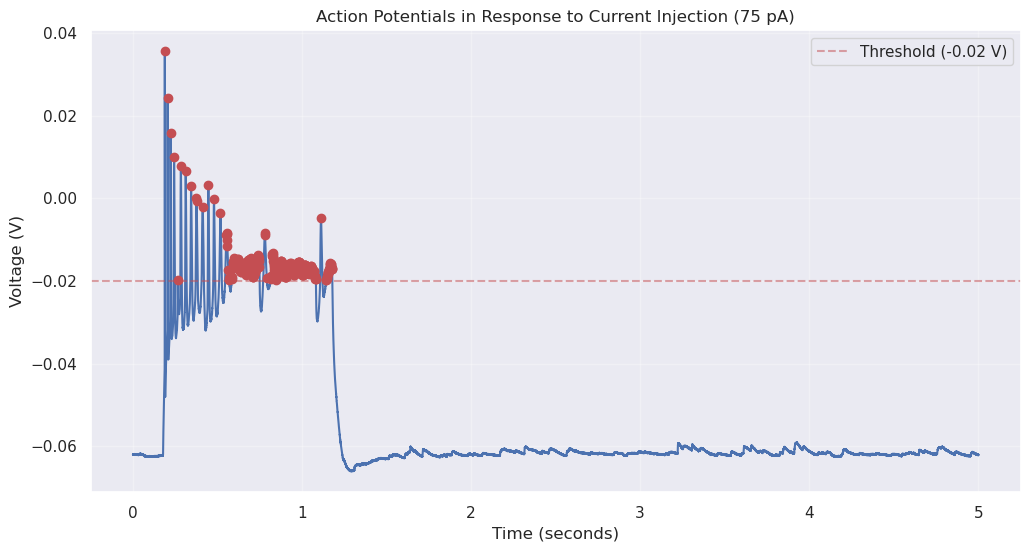

In [6]:
# Get a strong stimulus response that should contain action potentials
response_name = "current_clamp-response-19-ch-0"  # Try one with higher current
stimulus_name = "stimulus-19-ch-0"

if response_name in nwb_ephys.acquisition:
    response = nwb_ephys.acquisition[response_name]
    print(f"\nFound {response_name}")
    print(f"Description: {response.description}")
    
    # Get stimulus info
    if stimulus_name in nwb_ephys.stimulus:
        stimulus = nwb_ephys.stimulus[stimulus_name]
        current_pA = np.mean(stimulus.data[5000:25000]) * stimulus.conversion * 1e12  # Convert to pA
        print(f"Stimulus current: {current_pA:.2f} pA")
    
    # Load response data - full trace
    data = response.data[:]  # Load all data
    
    # Convert to actual voltage
    voltage_data = data * response.conversion
    
    # Create a time vector (in seconds)
    time = np.arange(len(voltage_data)) / response.rate
    
    # Find action potentials (voltage spikes)
    # We'll use a simple threshold approach
    threshold = -0.02  # 20 mV above resting, typical spike threshold
    resting_potential = np.mean(voltage_data[0:1000])  # Estimate resting from beginning
    print(f"Estimated resting potential: {resting_potential:.3f} V")
    
    # Use scipy.signal.find_peaks for more robust spike detection
    from scipy.signal import find_peaks
    
    # Detect action potentials using peak finding
    # First find where voltage crosses threshold
    above_threshold = voltage_data > threshold
    # Then use find_peaks to locate actual peaks
    peaks, _ = find_peaks(voltage_data, height=threshold, distance=int(0.001 * response.rate))  # Min 1ms between spikes
    crossings = peaks  # Use these peak indices for our analysis
    
    if len(crossings) > 0:
        print(f"Found {len(crossings)} action potentials")
        
        # Plot the entire trace with detected spikes
        plt.figure(figsize=(12, 6))
        plt.plot(time, voltage_data, 'b')
        plt.plot(time[crossings], voltage_data[crossings], 'ro')
        plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label=f'Threshold ({threshold} V)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Voltage (V)')
        plt.title(f'Action Potentials in Response to Current Injection ({current_pA:.0f} pA)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        print("No action potentials detected")
else:
    print(f"Could not find response {response_name}")

### 1.4 Single Action Potential Waveform Analysis

Let's zoom in on a single action potential to analyze its properties:


Action Potential Properties:
Amplitude: 97.75 mV
Half-width: 1.200 ms
Maximum upstroke: 179.44 V/s


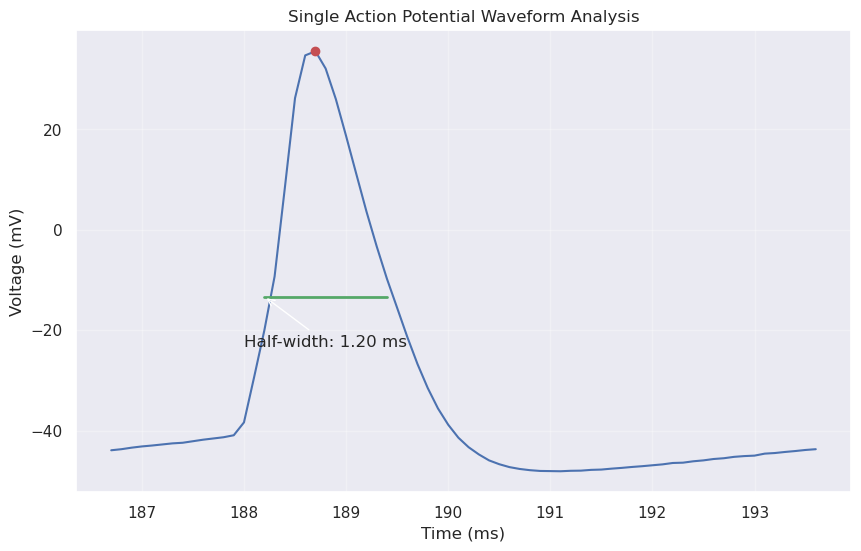

In [7]:
if len(crossings) > 0:
    # Take the first spike
    spike_index = crossings[0]
    
    # Extract a window around the spike (2ms before, 5ms after)
    pre_spike_pts = int(0.002 * response.rate)  # 2ms before
    post_spike_pts = int(0.005 * response.rate)  # 5ms after
    
    # Ensure we have enough data points
    if spike_index > pre_spike_pts and spike_index + post_spike_pts < len(voltage_data):
        spike_window = voltage_data[spike_index - pre_spike_pts:spike_index + post_spike_pts]
        spike_time = time[spike_index - pre_spike_pts:spike_index + post_spike_pts]
        
        # Calculate AP properties
        ap_amplitude = np.max(spike_window) - resting_potential
        
        # Find the peak and its index
        peak_index = np.argmax(spike_window)
        
        # Calculate the half-width
        # First, find the half-amplitude value
        half_amplitude = resting_potential + ap_amplitude / 2
        
        # Find the crossing points (improved method)
        above_half = spike_window > half_amplitude
        half_crossings = np.where(np.diff(above_half.astype(int)) != 0)[0]
        
        # Calculate half-width if we have two crossing points
        if len(half_crossings) >= 2:
            half_width = (spike_time[half_crossings[1]] - spike_time[half_crossings[0]]) * 1000  # in ms
        else:
            half_width = None
            
        # Calculate spike maximum upstroke (max dV/dt during rising phase)
        dv_dt = np.diff(spike_window) * response.rate  # V/s
        
        # Use points before the peak for upstroke
        max_upstroke = np.max(dv_dt[:peak_index])
        
        print(f"\nAction Potential Properties:")
        print(f"Amplitude: {ap_amplitude*1000:.2f} mV")
        if half_width:
            print(f"Half-width: {half_width:.3f} ms")
        else:
            print("Half-width: Could not be calculated")
        print(f"Maximum upstroke: {max_upstroke:.2f} V/s")
        
        # Plot the single AP with its properties
        plt.figure(figsize=(10, 6))
        plt.plot(spike_time * 1000, spike_window * 1000, 'b')  # Convert to ms and mV
        
        # Mark the peak
        plt.plot(spike_time[peak_index] * 1000, spike_window[peak_index] * 1000, 'ro')
        
        # Mark the half-width if available
        if half_width:
            plt.plot([spike_time[half_crossings[0]] * 1000, spike_time[half_crossings[1]] * 1000], 
                    [half_amplitude * 1000, half_amplitude * 1000], 'g-', linewidth=2)
            plt.annotate(f'Half-width: {half_width:.2f} ms', 
                        xy=(spike_time[half_crossings[0]] * 1000, half_amplitude * 1000),
                        xytext=(spike_time[half_crossings[0]] * 1000 - 0.2, half_amplitude * 1000 - 10),
                        arrowprops=dict(arrowstyle='->'))
        
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
        plt.title('Single Action Potential Waveform Analysis')
        plt.grid(True, alpha=0.3)

### 1.5 Frequency-Current (F-I) Curve

The frequency-current relationship shows how neuronal firing rate changes with different stimulus intensities:

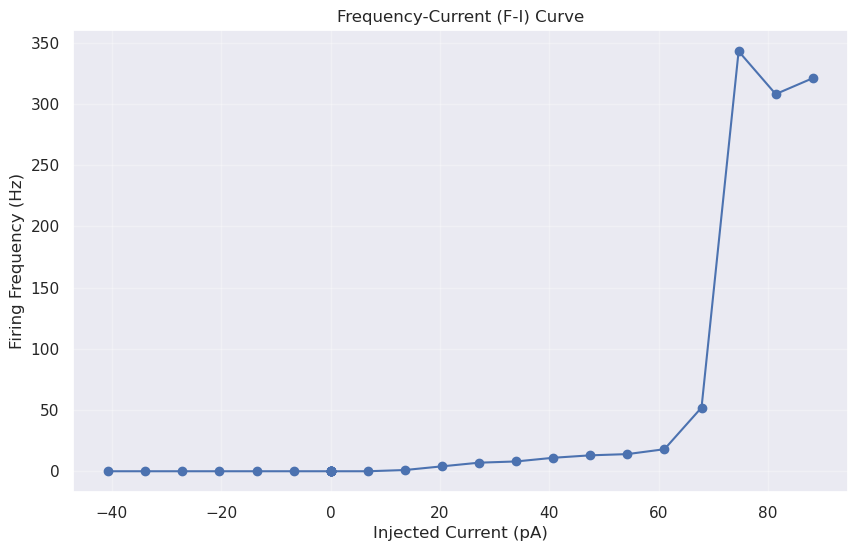

In [8]:
# Now create a frequency-current (F-I) curve
# Let's find several response traces with different stimulus intensities
response_series = []
stimulus_intensities = []

for i in range(2, 30):  # Look at a range of stimulus intensities
    response_key = f"current_clamp-response-{i:02d}-ch-0"
    stimulus_key = f"stimulus-{i:02d}-ch-0"
    
    if response_key in nwb_ephys.acquisition and stimulus_key in nwb_ephys.stimulus:
        response_data = nwb_ephys.acquisition[response_key].data[:] * nwb_ephys.acquisition[response_key].conversion
        stimulus_data = nwb_ephys.stimulus[stimulus_key].data[:] * nwb_ephys.stimulus[stimulus_key].conversion
        
        # Calculate mean stimulus current in pA
        current = np.mean(stimulus_data[5000:25000]) * 1e12  # Convert to pA
        
        # Count spikes using peak finding for improved accuracy
        peaks, _ = find_peaks(response_data, height=threshold, distance=int(0.001 * response.rate))
        
        # Filter to only include peaks during the stimulus period (0.5s to 1.5s)
        stimulus_start_idx = int(0.5 * response.rate)
        stimulus_end_idx = int(1.5 * response.rate)
        stim_period_peaks = [p for p in peaks if stimulus_start_idx <= p < stimulus_end_idx]
        spike_count = len(stim_period_peaks)
        
        # Calculate firing frequency in Hz (spikes per second)
        # Assuming 1s of stimulation from 0.5s to 1.5s
        frequency = spike_count  # Since we're looking at a 1-second window
        
        response_series.append(frequency)
        stimulus_intensities.append(current)

if response_series:
    # Sort by stimulus intensity
    sorted_indices = np.argsort(stimulus_intensities)
    sorted_intensities = [stimulus_intensities[i] for i in sorted_indices]
    sorted_frequencies = [response_series[i] for i in sorted_indices]
    
    # Plot F-I curve
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_intensities, sorted_frequencies, 'b-o')
    plt.xlabel('Injected Current (pA)')
    plt.ylabel('Firing Frequency (Hz)')
    plt.title('Frequency-Current (F-I) Curve')
    plt.grid(True, alpha=0.3)

## Part 2: Calcium Imaging Data Analysis

Next, we'll explore calcium imaging data from the central amygdala. Calcium imaging allows for the visualization of calcium signals in large populations of neurons simultaneously, providing insights into network activity.

In [9]:
# Define the URL for the calcium imaging NWB file
calcium_asset_id = "7ac3357c-06e4-4f04-a869-2f3a71524456"
calcium_url = f"https://api.dandiarchive.org/api/assets/{calcium_asset_id}/download/"
print(f"Loading calcium imaging NWB file: {calcium_asset_id} (sub-C370, image+ophys)")

# Load the file  
remote_file = remfile.File(calcium_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb_calcium = io.read()

# Display basic metadata
print(f"Session description: {nwb_calcium.session_description}")
print(f"Subject ID: {nwb_calcium.subject.subject_id}")
print(f"Experiment date: {nwb_calcium.session_start_time}")

Loading calcium imaging NWB file: 7ac3357c-06e4-4f04-a869-2f3a71524456 (sub-C370, image+ophys)


Session description: Group housed, Day 2, Stim OFF, 3/2/2023
Subject ID: C370
Experiment date: 2023-03-02 18:38:51+00:00


### 2.1 Examining Fluorescence Data

Let's examine the fluorescence data from the calcium imaging recording:


Found optical physiology (ophys) processing module
Description: Optical physiology data, processed with CNMFe

Found fluorescence data
ROI response data shape: (19211, 74)
Number of ROIs: 74
Number of time points: 19211
Sampling rate: 25.0 Hz


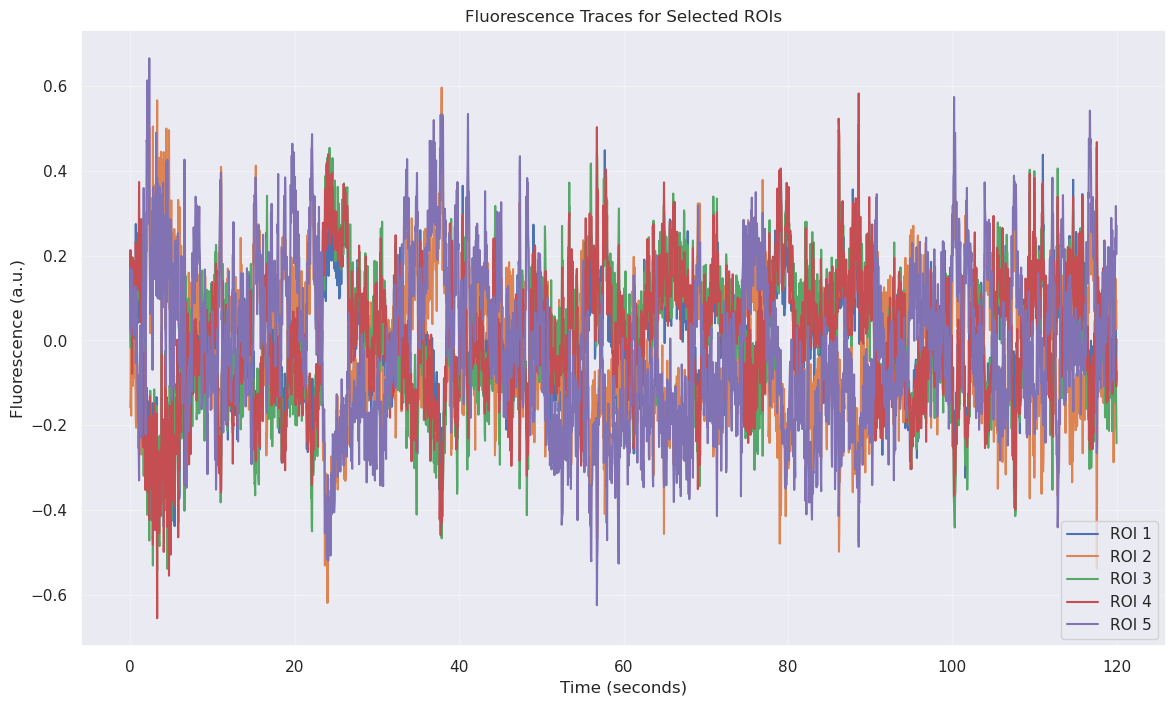

In [10]:
# Access the ophys module
if 'ophys' in nwb_calcium.processing:
    ophys = nwb_calcium.processing['ophys']
    print("\nFound optical physiology (ophys) processing module")
    print(f"Description: {ophys.description}")
    
    # Check if we have fluorescence data
    if 'Fluorescence' in ophys.data_interfaces:
        fluorescence = ophys.data_interfaces['Fluorescence']
        print("\nFound fluorescence data")
        
        if 'RoiResponseSeries' in fluorescence.roi_response_series:
            roi_response = fluorescence.roi_response_series['RoiResponseSeries']
            print(f"ROI response data shape: {roi_response.data.shape}")
            print(f"Number of ROIs: {roi_response.data.shape[1]}")
            print(f"Number of time points: {roi_response.data.shape[0]}")
            print(f"Sampling rate: {roi_response.rate} Hz")
            
            # Plot fluorescence responses for a few ROIs
            # Get the first few minutes of data for a few ROIs
            num_rois_to_plot = 5
            # Calculate how many time points for 2 minutes at the given sampling rate
            two_min_points = int(120 * roi_response.rate)
            # Limit data to first 2 minutes and first few ROIs
            data_subset = roi_response.data[0:two_min_points, 0:num_rois_to_plot]
            
            # Create a time vector (in seconds)
            time = np.arange(data_subset.shape[0]) / roi_response.rate
            
            # Plot the fluorescence traces
            plt.figure(figsize=(14, 8))
            for i in range(num_rois_to_plot):
                plt.plot(time, data_subset[:, i], label=f'ROI {i+1}')
            
            plt.xlabel('Time (seconds)')
            plt.ylabel('Fluorescence (a.u.)')
            plt.title('Fluorescence Traces for Selected ROIs')
            plt.legend()
            plt.grid(True, alpha=0.3)
else:
    print("No ophys processing module found in this file")

### 2.2 Calcium Activity Heatmap

A heatmap visualization can help us visualize activity patterns across multiple ROIs:

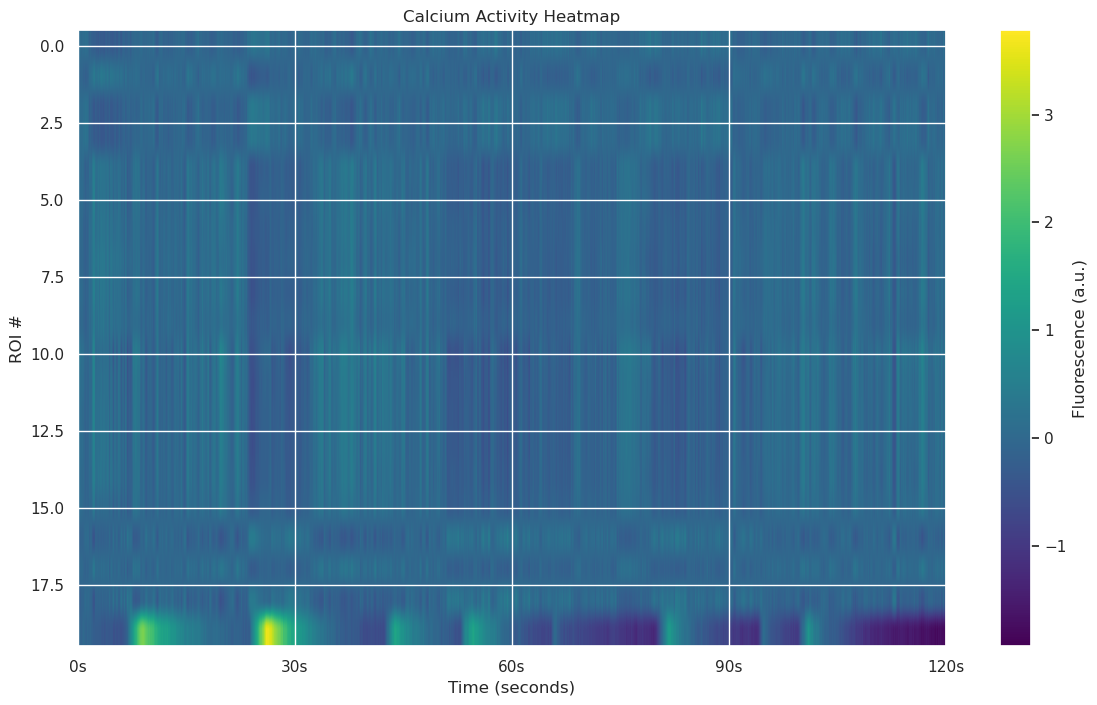

In [11]:
# Analyze activity for all ROIs using heatmap
if 'ophys' in nwb_calcium.processing and 'Fluorescence' in nwb_calcium.processing['ophys'].data_interfaces:
    # Use more ROIs for the heatmap
    num_rois_for_heatmap = 20
    # Limit to first 2 minutes
    roi_response = nwb_calcium.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries']
    two_min_points = int(120 * roi_response.rate)
    data_for_heatmap = roi_response.data[0:two_min_points, 0:num_rois_for_heatmap]
    
    plt.figure(figsize=(14, 8))
    plt.imshow(data_for_heatmap.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Fluorescence (a.u.)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('ROI #')
    plt.title('Calcium Activity Heatmap')
    
    # Add time ticks
    time_ticks = np.linspace(0, data_for_heatmap.shape[0], 5)
    time_labels = [f"{t/roi_response.rate:.0f}s" for t in time_ticks]
    plt.xticks(time_ticks, time_labels)

### 2.3 Analyzing Calcium Imaging Data Statistics

Let's calculate some basic statistics for the calcium imaging data to better understand the activity patterns:

,ROI,Mean,Std,Max,Min,Event Rate (Hz)
0,1,-0.015723,0.133638,0.645431,-0.500030,0.088491
1,2,-0.003709,0.145352,0.712907,-0.618737,0.093696
2,3,-0.015230,0.145192,0.626940,-0.597846,0.075478
3,4,-0.010276,0.146778,0.654425,-0.654838,0.078080
4,5,-0.001053,0.166399,0.917910,-0.624037,0.089792
5,6,0.001377,0.157309,0.863597,-0.561473,0.096299
6,7,0.002210,0.152406,0.821750,-0.505443,0.104107
7,8,-0.000309,0.159416,0.646188,-0.635763,0.083286
8,9,0.002918,0.172050,0.784461,-0.636361,0.105408
9,10,-0.002065,0.133630,0.559622,-0.507289,0.108011


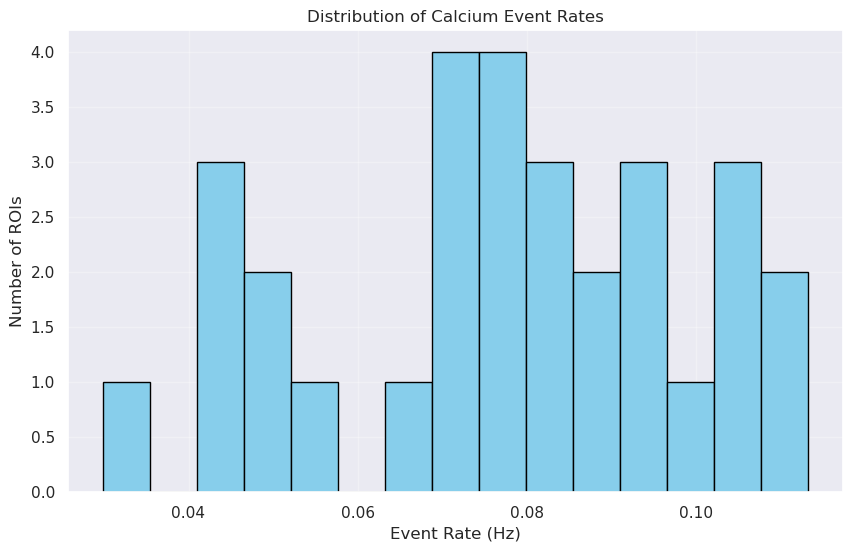

In [12]:
if 'ophys' in nwb_calcium.processing and 'Fluorescence' in nwb_calcium.processing['ophys'].data_interfaces:
    # Get fluorescence data
    roi_response = nwb_calcium.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries']
    
    # Calculate statistics for each ROI
    roi_stats = []
    
    # Use a larger number of ROIs
    num_rois = min(30, roi_response.data.shape[1])
    
    for i in range(num_rois):
        # Get calcium trace for this ROI
        trace = roi_response.data[:, i]
        
        # Calculate statistics
        mean_activity = np.mean(trace)
        std_activity = np.std(trace)
        max_activity = np.max(trace)
        min_activity = np.min(trace)
        
        # Improved event detection
        # First, normalize the trace (Z-score)
        normalized_trace = (trace - mean_activity) / std_activity
        
        # Use a more robust peak finding algorithm
        from scipy.signal import find_peaks
        # Require peaks to be at least 2.5 standard deviations above mean
        # and at least 0.5s apart (to avoid counting the same event multiple times)
        min_distance = int(0.5 * roi_response.rate)
        peaks, _ = find_peaks(normalized_trace, height=2.5, distance=min_distance)
        
        # Calculate event rate
        event_rate = len(peaks) / (len(trace) / roi_response.rate)  # Events per second
        
        roi_stats.append({
            'ROI': i+1,
            'Mean': mean_activity,
            'Std': std_activity,
            'Max': max_activity,
            'Min': min_activity,
            'Event Rate (Hz)': event_rate
        })
    
    # Create a dataframe and display
    stats_df = pd.DataFrame(roi_stats)
    display(stats_df)
    
    # Plot the distribution of event rates
    plt.figure(figsize=(10, 6))
    plt.hist(stats_df['Event Rate (Hz)'], bins=15, color='skyblue', edgecolor='black')
    plt.xlabel('Event Rate (Hz)')
    plt.ylabel('Number of ROIs')
    plt.title('Distribution of Calcium Event Rates')
    plt.grid(True, alpha=0.3)

## Summary and Future Directions

In this notebook, we explored two main types of data from Dandiset 001195:

1. **Intracellular Electrophysiology**: We analyzed patch-clamp recordings from dorsal raphe nucleus neurons, examining:
   - Current-voltage (I-V) relationships, which showed the passive membrane properties of the neurons
   - Action potential waveforms, revealing the characteristic firing patterns
   - Frequency-current (F-I) curves, demonstrating how neuronal firing rates change with stimulus intensity

2. **Calcium Imaging**: We examined one-photon calcium imaging data from the central amygdala (CeA), showing:
   - Fluorescence traces from individual neurons/ROIs
   - Activity patterns across multiple ROIs using heatmap visualization
   - Basic statistics of calcium activity

### Key Findings

- The electrophysiology recordings revealed typical neuronal response properties, including a linear I-V relationship and nonlinear F-I relationship with threshold effects.
- Calcium imaging data showed varying activity patterns across ROIs in the CeA, with some synchronized activity between certain neurons.

### Future Directions

Future analyses could include:

1. **Correlating electrophysiology with calcium imaging**: Investigating how single-cell properties relate to network activity.
2. **Behavioral correlates**: Examining how neural activity relates to social isolation or loneliness-like behaviors.
3. **Comparative analysis**: Comparing activity patterns between groups (e.g., socially isolated vs. group-housed animals).
4. **Cross-regional analysis**: Examining connectivity between the dorsal raphe nucleus and central amygdala.

This Dandiset offers rich opportunities for further exploration of neural mechanisms underlying social behavior and the neurobiology of loneliness-like states.